In [1]:
# Third Party Imports
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import math
from exphelperfunctions import abbrv_num
from exphelperfunctions import objectToFile
from exphelperfunctions import objectFromFile
from exphelperfunctions import add_value_labels

## Load original data

In [3]:
#Open CICIDS2018
columns = ['Dst Port','Flow Duration','Protocol','TotLen Fwd Pkts','TotLen Bwd Pkts','Fwd Pkt Len Mean','Bwd Pkt Len Mean','Tot Fwd Pkts','Tot Bwd Pkts','Fwd IAT Mean','Bwd IAT Mean','Fwd IAT Std','Label']
dtypes = {'Flow Duration':np.float64,'Protocol': np.int8,'TotLen Fwd Pkts':np.int32,'TotLen Bwd Pkts':np.int32,'Fwd Pkt Len Mean':np.float32,'Bwd Pkt Len Mean':np.float32,'Tot Fwd Pkts':np.int32,'Tot Bwd Pkts':np.int32,'Fwd IAT Mean':np.float64,'Bwd IAT Mean':np.float32, 'Fwd IAT Std': np.float32,'Label':object}

dirpath = "/mnt/h/CICIDS/2018/"

filepaths = [dirpath+f for f in os.listdir(dirpath) if f.endswith('.csv')]

print("Importing data, starting with: " + filepaths[0])
df = pd.read_csv(filepaths[0] ,sep=',',header=0, usecols=columns, dtype = dtypes, skipinitialspace=True)
for filename in filepaths[1:]:
    print("Concatenating: " + filename)
    df = pd.concat([df,pd.read_csv(filename, sep=',',header=0, usecols=columns, dtype= dtypes, skipinitialspace=True)],ignore_index=True)
    

Importing data, starting with: /mnt/h/CICIDS/2018/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
Concatenating: /mnt/h/CICIDS/2018/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
Concatenating: /mnt/h/CICIDS/2018/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
Concatenating: /mnt/h/CICIDS/2018/Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv
Concatenating: /mnt/h/CICIDS/2018/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
Concatenating: /mnt/h/CICIDS/2018/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
Concatenating: /mnt/h/CICIDS/2018/Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv
Concatenating: /mnt/h/CICIDS/2018/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv
Concatenating: /mnt/h/CICIDS/2018/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv
Concatenating: /mnt/h/CICIDS/2018/Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv


In [4]:
#Print general info and remove invalid rows
print(df.columns)
print(df['Label'].unique())
print(df.shape[0])
df = df.dropna()
df = df.drop(df[df['Flow Duration'] < 0].index)
print(df.shape[0])
print(df.describe())

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean',
       'Bwd Pkt Len Mean', 'Fwd IAT Mean', 'Fwd IAT Std', 'Bwd IAT Mean',
       'Label'],
      dtype='object')
['Benign' 'Bot' 'DoS attacks-SlowHTTPTest' 'DoS attacks-Hulk'
 'Brute Force -Web' 'Brute Force -XSS' 'SQL Injection'
 'DDoS attacks-LOIC-HTTP' 'Infilteration' 'DoS attacks-GoldenEye'
 'DoS attacks-Slowloris' 'FTP-BruteForce' 'SSH-Bruteforce'
 'DDOS attack-LOIC-UDP' 'DDOS attack-HOIC']
16232943
16232929
           Dst Port      Protocol  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  \
count  1.623293e+07  1.623293e+07   1.623293e+07  1.623293e+07  1.623293e+07   
mean   9.164081e+03  8.754121e+00   1.218932e+07  2.353313e+01  6.312711e+00   
std    1.892225e+04  4.920113e+00   3.088644e+07  1.521137e+03  1.640257e+02   
min    0.000000e+00  0.000000e+00   0.000000e+00  1.000000e+00  0.000000e+00   
25%    5.300000e+01  6.000000e+00   4.

# Add binary label and fix test label

In [5]:
df['BinLabel'] = np.where(df['Label'] == 'Benign', 'Benign','Malicious')
print(df['BinLabel'].value_counts())
print(df['Label'].value_counts())

Benign       13484694
Malicious     2748235
Name: BinLabel, dtype: int64
Benign                      13484694
DDOS attack-HOIC              686012
DDoS attacks-LOIC-HTTP        576191
DoS attacks-Hulk              461912
Bot                           286191
FTP-BruteForce                193360
SSH-Bruteforce                187589
Infilteration                 161934
DoS attacks-SlowHTTPTest      139890
DoS attacks-GoldenEye          41508
DoS attacks-Slowloris          10990
DDOS attack-LOIC-UDP            1730
Brute Force -Web                 611
Brute Force -XSS                 230
SQL Injection                     87
Name: Label, dtype: int64


# Data composition
Benign: 13,484,694 instances (83.1%)

Malicious: 2,748,235 instances (16.9%)
* DDoS HOIC: 686,012
* DDoS LOIC-HTTP: 576,191
* DoS Hulk: 461,912
* Bot: 286,191
* FTP BruteForce: 193,360
* SSH BruteForce: 187,589
* Infiltration: 161,934
* DoS SlowHTTPTest: 139,890
* DoS GoldenEye: 41,508
* DoS Slowloris: 10,990
* DDoS LOIC-UDP: 1,730
* BruteForce Web: 611
* BruteForce XSS: 230
* SQL Injection: 87

# One hot encoding

In [6]:
print(df['Protocol'].unique())

[ 6  0 17]


In [7]:
# One hot encoding for protocol
ohe_df = pd.get_dummies(df['Protocol'], prefix="proto")
df = df.join(ohe_df)

# Random Forest: Combine datasets and select features

In [9]:
#Get input columns and corresponding label vector
#Use duration, protocol, src bytes&packets per flow, dst bytes&packets per flow, mean src/dst bytes per flow, total/mean IAT
features = ['Flow Duration','proto_0','proto_6','proto_17','TotLen Fwd Pkts','TotLen Bwd Pkts','Fwd Pkt Len Mean','Bwd Pkt Len Mean','Tot Fwd Pkts','Tot Bwd Pkts','Fwd IAT Mean','Bwd IAT Mean','Fwd IAT Std']
#kilincer et al.: add ports to features to see impact. Comment out if using general feature set only.
#features.append('Dst Port')
label = 'BinLabel'
skf = StratifiedKFold(n_splits=5)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
cfs = []
preds = []
for train_idxs, test_idxs in skf.split(df[features], df['Label']):
    print("TRAIN:", (len(train_idxs)), "TEST:", (len(test_idxs)))
    X_train = df[features].iloc[train_idxs,:]
    X_test = df[features].iloc[test_idxs,:]
    y_train = df[label].iloc[train_idxs]
    y_test = df[label].iloc[test_idxs]
    #Apply Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100,min_samples_split=10,min_samples_leaf=5,max_samples=0.8,criterion='gini',n_jobs=5, verbose=10)
    rf_clf.fit(X_train,y_train)
    y_pred = rf_clf.predict(X_test)
    cfs.append(confusion_matrix(y_test, y_pred))
    preds.append([y_test, y_pred])

TRAIN: 12986343 TEST: 3246586


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   34.2s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  1.1min


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.7min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  2.7min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  3.7min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  4.4min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  5.8min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  6.9min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  8.2min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  9.7min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 10.9min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    7.6s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    8.9s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    9.9s finished


TRAIN: 12986343 TEST: 3246586


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100

building tree 4 of 100building tree 5 of 100


building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   32.6s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  1.1min


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.6min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  2.5min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  3.4min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  4.3min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  5.4min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  6.6min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  7.8min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  9.2min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 10.4min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    9.2s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   10.9s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   12.2s finished


TRAIN: 12986343 TEST: 3246586


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   32.7s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  1.1min


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.6min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  2.6min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  3.5min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  4.1min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  5.5min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  6.7min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  8.0min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  9.3min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 10.4min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    7.6s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    9.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   10.6s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   12.0s finished


TRAIN: 12986343 TEST: 3246586


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100


building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   30.1s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  1.0min


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.6min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  2.5min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  3.4min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  4.1min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  5.3min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  6.5min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  7.5min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  8.9min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  9.9min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    8.6s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    9.6s finished


TRAIN: 12986344 TEST: 3246585


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100


building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   31.4s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   59.5s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.5min


building tree 21 of 100
building tree 22 of 100building tree 23 of 100

building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  2.4min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  3.4min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  4.0min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  5.2min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  6.2min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  7.4min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  8.8min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  9.8min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    9.1s finished


### Calculate general metrics (confusion matrix, mean/std. dev.)

In [11]:
print(cfs)
cf = np.mean(cfs,axis=(0))
cf_std = np.std(cfs,axis=0)
print(cf)
print(cf_std)
#objectToFile(preds, "cicids2018_preds_"+label)

[array([[2683652,   13287],
       [  37445,  512202]]), array([[2687893,    9046],
       [  36456,  513191]]), array([[2691358,    5581],
       [  35373,  514274]]), array([[2676406,   20533],
       [  35769,  513878]]), array([[2623319,   73619],
       [  32184,  517463]])]
[[2672525.6   24413.2]
 [  35445.4  514201.6]]
[[25103.62538439 25103.23335668]
 [ 1775.74779741  1775.74779741]]


In [3]:
#Load results from file if needed
from sklearn.metrics import confusion_matrix
label='BinLabel'
preds_mem = objectFromFile("cicids2018_preds_"+label)
cfs = []
for pred_tuple in preds_mem:
    cfs.append(confusion_matrix(pred_tuple[0], pred_tuple[1]))

### Calculate accuracy, TPR and TNR, compare to related work

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
paper1_acc = 0.9960
paper1_rec = 0.9901
tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
print(tn,fp,fn,tp)

acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds]
rec_score  = tp / (tp+fn)
spec_score = tn / (tn+fp)
print(np.mean(acc_scores), "\n")
print(rec_score, "\n")
print(spec_score)
print(fp / (fp+tn))

2672525.6 24413.2 35445.4 514201.6
0.9815625994451395 

0.935512428886176 

0.9909478109032358
0.009052189096764078


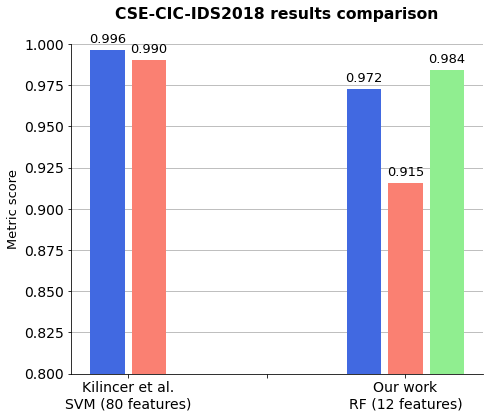

In [7]:
import matplotlib.patches as mpatches
#Colors
clr_acc = 'royalblue'
clr_rec = 'salmon'
clr_spec = 'lightgreen'

acc_patch = mpatches.Patch(color=clr_acc, label='accuracy')
rec_patch = mpatches.Patch(color=clr_rec, label='recall')
spec_patch = mpatches.Patch(color=clr_spec, label='specificity')

labels = ['Kilincer et al.\nSVM (80 features)', '', 'Our work\nRF (12 features)']
x = np.arange(len(labels))*10
width = 2.5  # the width of the bars
pad_width = 3
scores = [paper1_acc,paper1_rec,np.mean(acc_scores),rec_score,spec_score]

fig, ax = plt.subplots(figsize=(7,6))

#Spawn bar(s) of group 1
plt.bar(x[0]-pad_width/2, height=scores[0], width=width, color=clr_acc)
plt.bar(x[0]+pad_width/2, height=scores[1], width=width, color=clr_rec)

#Spawn bar(s) of group 2
plt.bar(x[2]-pad_width, height=scores[2], width=width, color=clr_acc)
plt.bar(x[2], height=scores[3], width=width, color=clr_rec)
plt.bar(x[2]+pad_width, height=scores[4], width=width, color=clr_spec)

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#Set plot details
plt.rc('font', size=13)
plt.ylabel('Metric score', fontsize=13)
plt.yticks(size='14')
plt.xticks(size='14')
plt.ylim([0.8, 1])
plt.title("CSE-CIC-IDS2018 results comparison", fontweight='bold',  pad=25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
add_value_labels(ax)
#ax.legend(handles=[acc_patch,rec_patch,spec_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_axisbelow(True)
plt.grid(axis='y')
fig.tight_layout()
plt.savefig('CICIDS2018_binaryclass_bars.png',bbox_inches='tight')
plt.show()

In [26]:
print('std. dev %\n', np.divide(np.std(cfs,axis=0),np.mean(cfs,axis=0))*100)

std. dev %
 [[ 1.15047484 70.8123842 ]
 [ 4.62578426  0.42778442]]


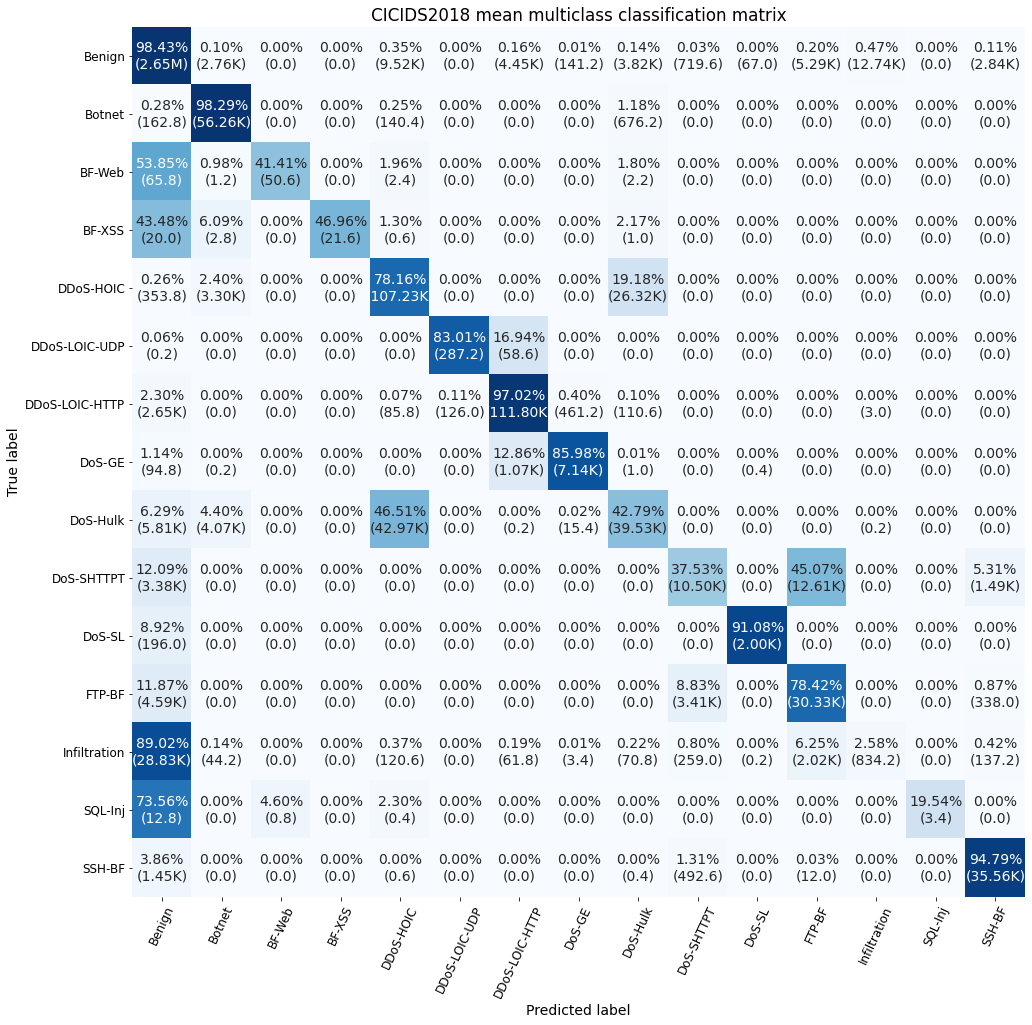

In [19]:
#Plot confusion matrix
import seaborn as sns

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', size=14)
#plot_confusion_matrix(rf_clf, df_test, y_test, ax=ax, normalize='true',xticks_rotation=30)
column_labels = sorted(y_test.unique())
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, \
            xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0',size=12)
plt.xticks(rotation='65',size=12)
plt.title("CICIDS2018 mean binary classification matrix")
plt.savefig('CICIDS2018_multiclass_cf.png',bbox_inches='tight')
plt.show()

In [13]:
importance = rf_clf.feature_importances_
# summarize feature importances
for i,v in sorted(enumerate(importance),key=lambda x: x[1], reverse=True):
    print('Feature: %s, Score: %.5f' % (features[i],v))

Feature: Flow Duration, Score: 0.22411
Feature: Fwd IAT Mean, Score: 0.15853
Feature: TotLen Fwd Pkts, Score: 0.12474
Feature: Fwd Pkt Len Mean, Score: 0.11369
Feature: Fwd IAT Std, Score: 0.07804
Feature: Tot Bwd Pkts, Score: 0.06239
Feature: Bwd Pkt Len Mean, Score: 0.05051
Feature: TotLen Bwd Pkts, Score: 0.05034
Feature: Tot Fwd Pkts, Score: 0.04993
Feature: Bwd IAT Mean, Score: 0.03721
Feature: proto_6, Score: 0.02811
Feature: proto_17, Score: 0.01844
Feature: proto_0, Score: 0.00397


[array([[2668803,   28136],
       [  48194,  501453]]), array([[2675763,   21176],
       [  49080,  500567]]), array([[2677095,   19844],
       [  45060,  504587]]), array([[2652560,   44379],
       [  48397,  501250]]), array([[2595980,  100958],
       [  43179,  506468]])]

Mean:
    
[[2654040.2   42898.6]
 [  46782.   502865. ]]

Std. Dev:
    
[[30313.43571026 30313.05264469]
 [ 2272.86893595  2272.86893595]]

# Rerun experiment with less features to confirm feature importances

In [8]:
#Get input columns and corresponding label vector
#Use duration, protocol, src bytes&packets per flow, dst bytes&packets per flow, mean src/dst bytes per flow, total/mean IAT
#features = ['Flow Duration','TotLen Fwd Pkts','Fwd Pkt Len Mean','Fwd IAT Mean']
features = ['Flow Duration','TotLen Fwd Pkts','Fwd IAT Mean']
label = 'BinLabel'
skf = StratifiedKFold(n_splits=5)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
cfs = []
preds = []
for train_idxs, test_idxs in skf.split(df[features], df['Label']):
    print("TRAIN:", (len(train_idxs)), "TEST:", (len(test_idxs)))
    X_train = df[features].iloc[train_idxs,:]
    X_test = df[features].iloc[test_idxs,:]
    y_train = df[label].iloc[train_idxs]
    y_test = df[label].iloc[test_idxs]
    #Apply Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100,min_samples_split=10,min_samples_leaf=5,max_samples=0.8,criterion='gini',n_jobs=5, verbose=10)
    rf_clf.fit(X_train,y_train)
    y_pred = rf_clf.predict(X_test)
    cfs.append(confusion_matrix(y_test, y_pred))
    preds.append([y_test, y_pred])

TRAIN: 12986343 TEST: 3246586


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   26.1s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   51.2s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.3min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  2.1min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.9min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.5min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  4.6min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  5.4min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  6.4min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  7.5min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  8.4min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    8.8s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    9.8s finished


TRAIN: 12986343 TEST: 3246586


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100

building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   24.7s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   48.5s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.2min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  2.0min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.6min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.2min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  4.1min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  4.9min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  5.9min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  6.9min


building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  7.7min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    7.6s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    9.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   10.6s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   11.9s finished


TRAIN: 12986343 TEST: 3246586


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100

building tree 4 of 100building tree 5 of 100


building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   25.2s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100building tree 14 of 100



[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   47.6s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.2min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  1.9min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.6min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.1min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  4.0min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  5.0min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  5.9min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  6.9min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  7.7min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   11.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   12.4s finished


TRAIN: 12986343 TEST: 3246586


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   25.7s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   49.7s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.2min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  2.0min


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.7min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.2min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  4.2min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  4.9min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  5.9min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  6.9min


building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  7.8min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    9.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   10.4s finished


TRAIN: 12986344 TEST: 3246585


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100building tree 4 of 100


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   24.8s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   50.0s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.3min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  2.0min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.8min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.2min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  4.3min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  5.1min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  6.0min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  7.0min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  7.9min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    7.7s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    9.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   10.2s finished


In [10]:
print(cfs)
cf = np.mean(cfs,axis=(0))
cf_std = np.std(cfs,axis=0)
print(cf)
print(cf_std)

[array([[2419577,  277362],
       [  62366,  487281]]), array([[2669578,   27361],
       [  53131,  496516]]), array([[2670237,   26702],
       [  50094,  499553]]), array([[2646791,   50148],
       [  53578,  496069]]), array([[2607475,   89463],
       [  50118,  499529]])]
[[2602731.6   94207.2]
 [  53857.4  495789.6]]
[[94376.64784808 94376.65790099]
 [ 4497.73914762  4497.73914762]]


In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
paper1_acc = 0.9960
paper1_rec = 0.9901
tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
print(tn,fp,fn,tp)

acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds]
rec_score  = tp / (tp+fn)
spec_score = tn / (tn+fp)
print(np.mean(acc_scores), "\n")
print(rec_score, "\n")
print(spec_score)
print(fp / (fp+tn))

2602731.6 94207.2 53857.4 495789.6
0.9543937512825365 

0.9020145657121752 

0.9650688402717925
0.0349311597282074


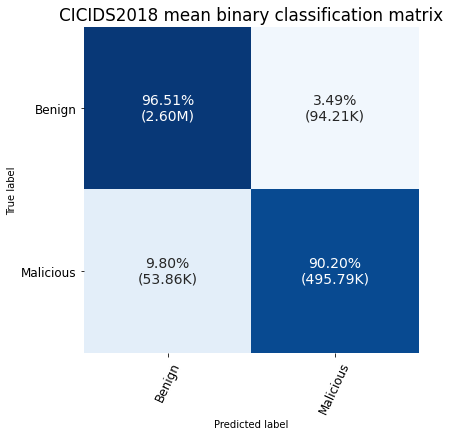

In [13]:
#Plot confusion matrix
import seaborn as sns

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', size=14)
#plot_confusion_matrix(rf_clf, df_test, y_test, ax=ax, normalize='true',xticks_rotation=30)
column_labels = sorted(y_test.unique())
#column_labels = ['Benign','Botnet','BF-Web','BF-XSS','DDoS-HOIC','DDoS-LOIC-UDP','DDoS-LOIC-HTTP', \
#                'DoS-GE','DoS-Hulk','DoS-SHTTPT','DoS-SL','FTP-BF','Infiltration','SQL-Inj','SSH-BF']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, \
            xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0',size=12)
plt.xticks(rotation='65',size=12)
plt.title("CICIDS2018 mean binary classification matrix - top three features")
#plt.savefig('CICIDS2018_multiclass_cf.png',bbox_inches='tight')
plt.show()